## Suavização Exponencial (Exponential Smoothing)

A suavização exponencial é uma técnica de previsão que atribui pesos decrescentes às observações passadas, com maior peso para as observações mais recentes.

### Dados

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [20]:
def transform_data_global(y_train, y_test):
    """
    Transforma os dados de treinamento e teste com o mesmo offset, 
    calculado a partir do menor valor em ambos os conjuntos.
    Retorna os dados transformados e o offset aplicado.
    """
    offset = -min(y_train.min(), y_test.min()) + 1 if min(y_train.min(), y_test.min()) <= 0 else 0
    y_train_transformed = y_train + offset
    y_test_transformed = y_test + offset
    return y_train_transformed, y_test_transformed, offset

def inverse_transform_data(y_transformed, offset):
    """
    Reverte a transformação aplicada para retornar os dados ao espaço original.
    """
    return y_transformed - offset


In [21]:
# Carregar os dados
data = pd.read_csv('us_change.csv')
data['Quarter'] = data['Quarter'].str.replace(' ', '')

# Converter 'Quarter' para datetime usando PeriodIndex
data['Quarter'] = pd.PeriodIndex(data['Quarter'], freq='Q')
data.set_index('Quarter', inplace=True)

# Selecionar a variável de interesse
y = data['Consumption']

# Dividir em conjunto de treinamento e teste
train_size = int(len(y) * 0.93)
y_train, y_test = y[:train_size], y[train_size:]
y_train_transformed, y_test_transformed, offset = transform_data_global(y_train, y_test)    


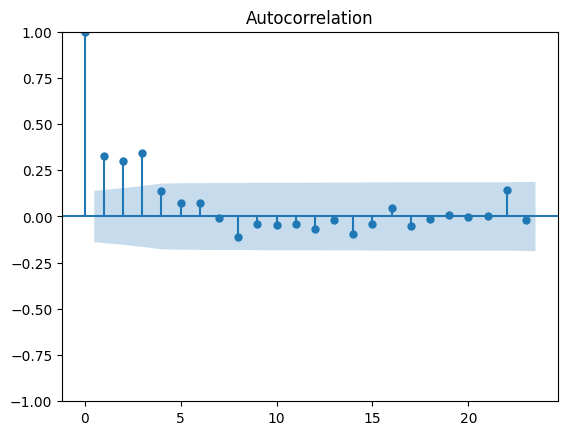

In [22]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(y)
plt.show()

# Overview dos possíveis modelos

Aqui vamos passar por todos os modelos possíveis e ver qual se ajusta melhor aos dados. Para isso, vamos utilizar cross validation no final para comparar os modelos.

Primeiramente, vamos criar algumas funções uteis que vão nos auxiliar a plotar os modelos e comparar os resultados.


In [68]:

def plot_all_models(y_train, y_test, models, params, offset, title, label, confidence_interval=False):
    """
    Plota previsões de múltiplos modelos no mesmo gráfico.
    """

    plt.figure(figsize=(12, 6))
    
    # Converter o índice para datetime
    y_train_inv = inverse_transform_data(y_train, offset)
    y_test_inv = inverse_transform_data(y_test, offset)
    y_train_inv.index = y_train_inv.index.to_timestamp()
    y_test_inv.index = y_test_inv.index.to_timestamp()
    
    # Plotar os dados reais
    plt.plot(y_train_inv, label="Treinamento", color="black")
    plt.plot(y_test_inv, label="Teste", color="blue")

    # Cores para os modelos
    colors = ["red", "green", "purple", "orange", "brown"]
    
    # Plotar previsões de cada modelo
    for i, param in enumerate(params):
        y_pred_train_inv, y_pred_test_inv, lower_conf_forecast, upper_conf_forecast = predict_train_and_test_sets(y_train, y_test, models, param, offset)

        # Plotar previsões para o conjunto de teste
        plt.plot(
            y_pred_test_inv,
            label=f"Previsão Teste ({label}={param[label]})",
            color=colors[i % len(colors)]
        )
        
        if confidence_interval: 
            # Plotar intervalo de confiança
            plt.fill_between(
                y_pred_test_inv.index,
                lower_conf_forecast,
                upper_conf_forecast,
                color=colors[i % len(colors)],
                alpha=0.2
            )

    plt.legend()
    plt.title(title)
    plt.show()


def plot_model(y_train, y_test, models, param, offset, title, label):
    """
    Plota previsões de um modelo no mesmo gráfico, incluindo previsões no treinamento, teste,
    resíduos, exibe métricas de erro e realiza o teste de Ljung-Box.
    """
    y_train_inv, y_test_inv = prepare_data(y_train, y_test, offset)
    y_pred_train_inv, y_pred_test_inv, lower_conf_forecast, upper_conf_forecast = predict_train_and_test_sets(y_train, y_test, models, param, offset)
    
    plot_predictions(y_train_inv, y_test_inv, y_pred_train_inv, y_pred_test_inv, lower_conf_forecast, upper_conf_forecast, title, label, param)
    plot_residuals(y_train_inv, y_pred_train_inv, f"Resíduos no Treinamento ({label}={param[label]})")
    
    calculate_and_display_metrics(y_test_inv, y_pred_test_inv, param)
    perform_ljung_box_test(y_test_inv - y_pred_test_inv)

def prepare_data(y_train, y_test, offset):
    """
    Converte o índice para datetime e inverte a transformação dos dados.
    """
    y_train_inv = inverse_transform_data(y_train, offset)
    y_test_inv = inverse_transform_data(y_test, offset)
    y_train_inv.index = y_train_inv.index.to_timestamp()
    y_test_inv.index = y_test_inv.index.to_timestamp()
    return y_train_inv, y_test_inv

def plot_predictions(y_train_inv, y_test_inv, y_pred_train_inv, y_pred_test_inv, lower_conf_forecast, upper_conf_forecast, title, label, param):
    """
    Plota os dados reais e as previsões, incluindo o intervalo de confiança.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(y_train_inv, label="Treinamento (Real)", color="black")
    plt.plot(y_test_inv, label="Teste (Real)", color="blue")
    plt.plot(y_pred_train_inv, label=f"Previsão Treinamento ({label}={param[label]})", linestyle="--", color="green")
    plt.plot(y_pred_test_inv, label=f"Previsão Teste ({label}={param[label]})", color="red")
    plt.fill_between(y_pred_test_inv.index, lower_conf_forecast, upper_conf_forecast, color="red", alpha=0.2)
    plt.legend()
    plt.title(title)
    plt.show()

def plot_residuals(y_real, y_pred, title="Resíduos vs Valores Ajustados"):
    """
    Plota um gráfico de dispersão dos resíduos contra os valores ajustados.
    """
    residuals = y_real - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--", linewidth=1)
    plt.title(title)
    plt.xlabel("Valores Ajustados")
    plt.ylabel("Resíduos")
    plt.show()

def calculate_and_display_metrics(y_test_inv, y_pred_test_inv, param):
    """
    Calcula e exibe métricas de erro.
    """
    mae = mean_absolute_error(y_test_inv, y_pred_test_inv)
    mse = mean_squared_error(y_test_inv, y_pred_test_inv)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test_inv - y_pred_test_inv) / y_test_inv)) * 100
    r2 = r2_score(y_test_inv, y_pred_test_inv)
    aic = len(y_test_inv) * np.log(mse) + 2 * len(param)
    bic = len(y_test_inv) * np.log(mse) + len(param) * np.log(len(y_test_inv))

    print('Métricas para o conjunto de teste:')
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAPE: {mape}%")
    print(f"R²: {r2}")
    print(f"AIC: {aic}")
    print(f"BIC: {bic}")

def perform_ljung_box_test(residuals, lags=[10]):
    """
    Realiza o teste de Ljung-Box nos resíduos e exibe os resultados.
    """
    ljung_box_results = acorr_ljungbox(residuals, lags=lags, return_df=True)
    print("\nTeste de Ljung-Box:")
    print(ljung_box_results)


def predict_train_and_test_sets(y_train, y_test, model, param, offset):
    """
    Faz a predição para os conjuntos de treinamento e teste, retornando as previsões e intervalos de confiança.
    """
    # Criar e ajustar o modelo
    model = ETSModel(y_train, **model)
    fit = model.fit_constrained(param, disp=0)

    # Previsão para o conjunto de treinamento
    y_pred_train = fit.fittedvalues

    # Previsão para o conjunto de teste
    y_pred_test = fit.forecast(steps=len(y_test))

    # Inverter as transformações
    y_pred_train_inv = inverse_transform_data(y_pred_train, offset)
    y_pred_train_inv.index = y_train.index.to_timestamp()

    y_pred_test_inv = inverse_transform_data(y_pred_test, offset)
    y_pred_test_inv.index = y_test.index.to_timestamp()

    # Intervalo de confiança para o conjunto de teste
    ci = fit.get_prediction(start=y_pred_test.index[0], end=y_pred_test.index[-1])

    lower_conf_forecast = ci.pred_int(alpha=0.05).iloc[:, 0] - offset
    upper_conf_forecast = ci.pred_int(alpha=0.05).iloc[:, 1] - offset

    return y_pred_train_inv, y_pred_test_inv, lower_conf_forecast, upper_conf_forecast


### Suavização Exponencial Simples

A suavização exponencial simples é uma técnica de previsão que atribui maior peso às observações mais recentes e pesos decrescentes às mais antigas. É ideal para séries temporais que não apresentam **tendência** ou **sazonalidade**.

#### Fórmula Geral
A previsão para o próximo período ($ \hat{y}_{t+1|t} $) é dada por:

$$
\hat{y}_{t+1|t} = \alpha y_t + (1 - \alpha)\hat{y}_{t|t-1}
$$


- **$\alpha$**: Parâmetro de suavização ($0 < \alpha \leq 1$):
  - Valores altos ($\alpha \to 1$) dão maior peso às observações mais recentes (similar ao método ingênuo).
  - Valores baixos ($\alpha \to 0$) atribuem pesos quase iguais às observações passadas (similar à média simples).

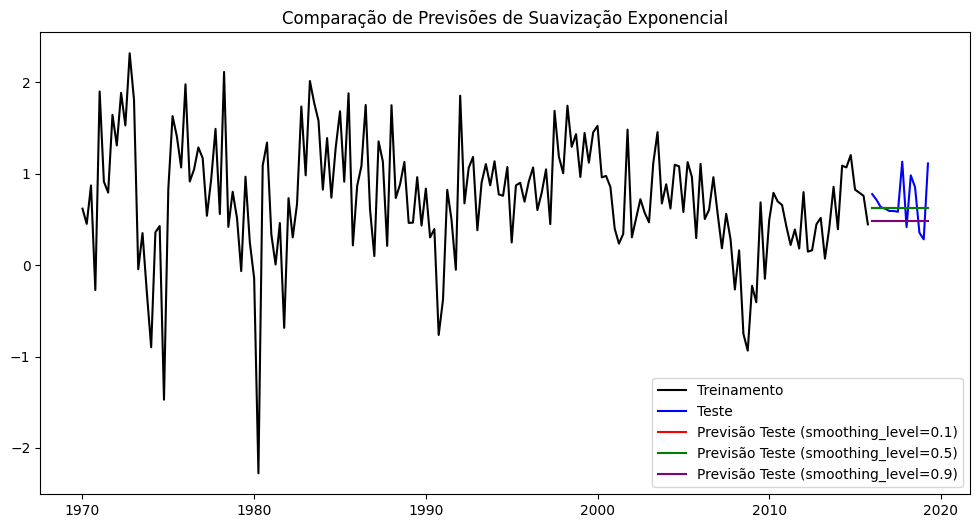

In [69]:
models = {'trend': None, 'seasonal': None, 'damped_trend': False}

params = [
    {'smoothing_level': 0.1},
    {'smoothing_level': 0.5},
    {'smoothing_level': 0.9}
]

plot_all_models(
    y_train=y_train_transformed,
    y_test=y_test_transformed,
    models=models,
    params=params,
    offset=offset,
    title="Comparação de Previsões de Suavização Exponencial",
    label='smoothing_level'
)


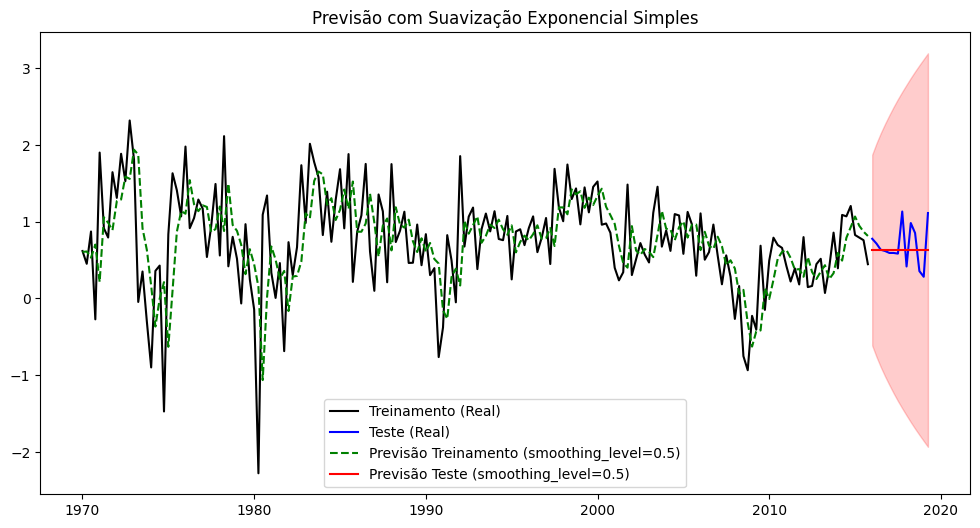

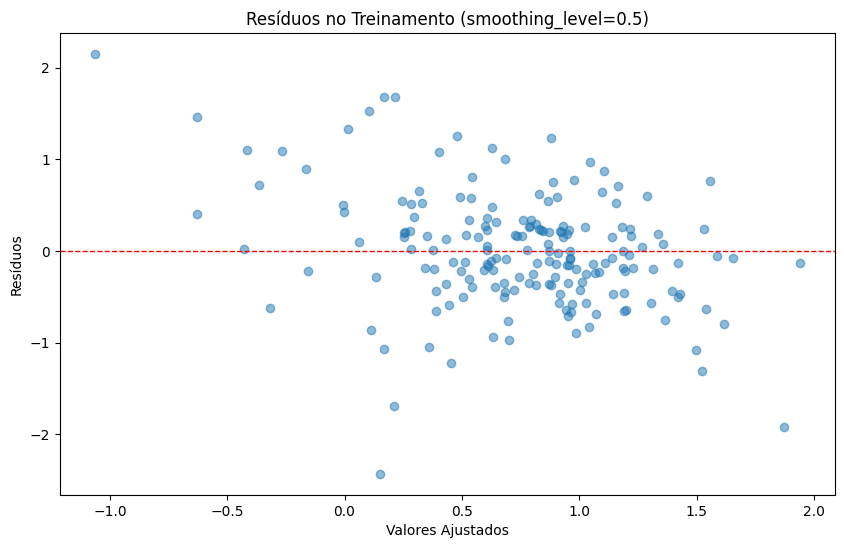

Métricas para o conjunto de teste:
MAE: 0.19754166101238876
MSE: 0.06678151702331295
RMSE: 0.258421200800772
MAPE: 32.484123363443274%
R²: -0.055024635306409
AIC: -35.888604991907584
BIC: -35.24954766229233

Teste de Ljung-Box:
     lb_stat  lb_pvalue
10  8.268455   0.602633


In [71]:
models = {'trend': None, 'seasonal': None, 'damped_trend': False}

params = {'smoothing_level': 0.5}

plot_model(
    y_train=y_train_transformed,
    y_test=y_test_transformed,
    models=models,
    param=params,
    offset=offset,
    title="Previsão com Suavização Exponencial Simples",
    label='smoothing_level'
)


Podemos notar que quanto mais $alpha$ se aproxima de 0, mais a série se aproxima do modelo de média. Por outro lado, quanto mais $alpha$ se aproxima de 1, mais a série se aproxima do modelo ingênuo.

Como nosso modelo tem sazonalizade, podemos ver que esse modelo não é suficiente para modelar nossa série.

#### Residual Analysis

### Método de Holt (Tendência Linear):

O **método de Holt** é uma extensão da suavização exponencial simples, projetado para séries temporais que apresentam uma **tendência linear** ao longo do tempo. Ele considera dois componentes principais:
1. **Nível** ($l_t$): Valor base da série no tempo $t$.
2. **Tendência** ($b_t$): Taxa de crescimento ou declínio da série no tempo $t$.

#### Fórmula Geral

A previsão para $h$ períodos à frente ($ \hat{y}_{T+h|T} $) é dada por:

$$
\hat{y}_{T+h|T} = l_T + h \cdot b_T
$$

- $l_T$: Nível estimado no tempo $T$.
- $b_T$: Tendência estimada no tempo $T$.
- $h$: Horizonte de previsão.


**Equação do Nível**
O nível ($l_t$) é ajustado com base no valor observado atual ($y_t$) e no nível ajustado pela tendência do período anterior ($l_{t-1} + b_{t-1}$):

$$
l_T = \alpha y_T + (1 - \alpha)(l_{T-1} + b_{T-1})
$$

- $\alpha$: Parâmetro de suavização do nível ($0 < \alpha \leq 1$).


 **Equação da Tendência**
A tendência ($b_t$) é ajustada com base na diferença entre os níveis atual e anterior:

$$
b_T = \beta^* (l_T - l_{T-1}) + (1 - \beta^*) b_{T-1}
$$

- $\beta^*$: Parâmetro de suavização da tendência ($0 \leq \beta^* \leq 1$).




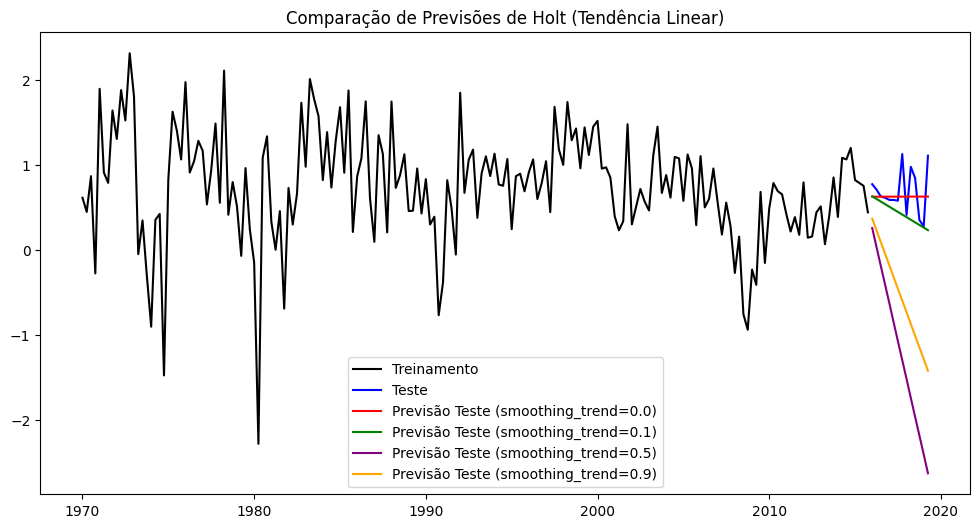

In [72]:
models = {'trend': 'add', 'seasonal': None, 'damped_trend': False}

# fixando o smoothing level em 0.5 para comparar apenas o smoothing trend
params = [
    {'smoothing_level': 0.5, 'smoothing_trend': 0.0},
    {'smoothing_level': 0.5, 'smoothing_trend': 0.1},
    {'smoothing_level': 0.5, 'smoothing_trend': 0.5},
    {'smoothing_level': 0.5, 'smoothing_trend': 0.9},
]

plot_all_models(
    y_train=y_train_transformed,
    y_test=y_test_transformed,
    models=models,
    params=params,
    offset=offset,
    title="Comparação de Previsões de Holt (Tendência Linear)",
    label='smoothing_trend'
)


Podemos ver que quanto mais $beta^*$ se aproxima de 0, mais a série se aproxima do modelo de suavização exponencial simples. Como nosso modelo não possue uma tendencia muito clara, podemos utilizar um valor de $beta^*$ próximo de 0.


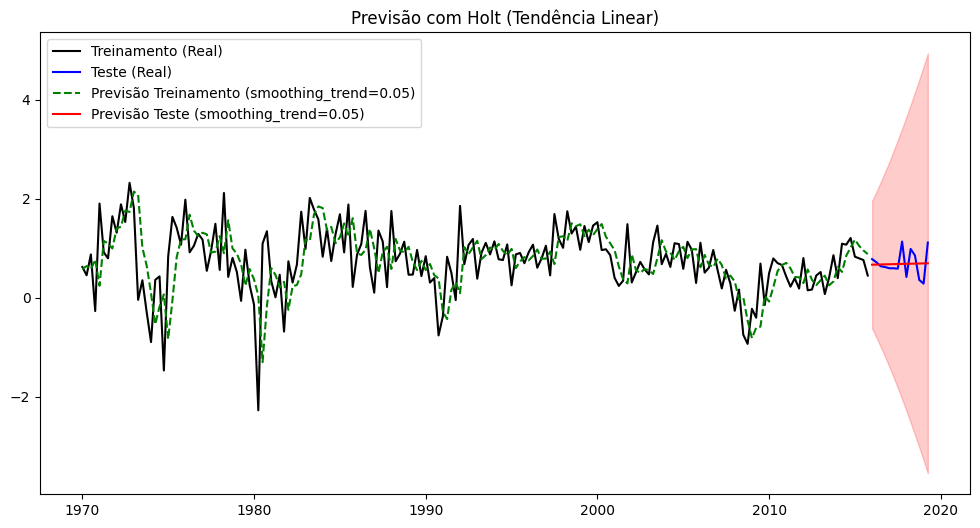

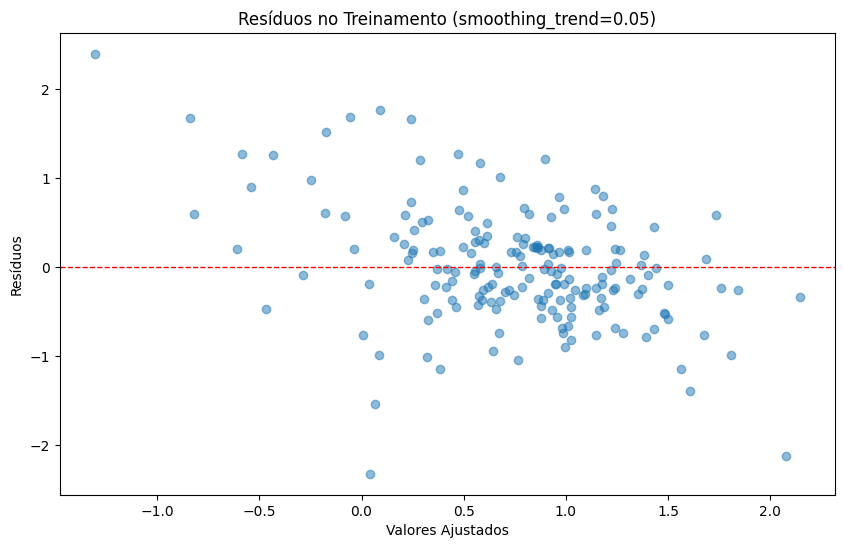

Métricas para o conjunto de teste:
MAE: 0.2036457670126513
MSE: 0.06336656287369402
RMSE: 0.2517271595869107
MAPE: 36.30627939641216%
R²: -0.0010746665593364124
AIC: -34.62346538584132
BIC: -33.3453507266108

Teste de Ljung-Box:
     lb_stat  lb_pvalue
10  8.203184   0.608998


In [73]:
models = {'trend': 'add', 'seasonal': None, 'damped_trend': False}

params = {'smoothing_level': 0.5, 'smoothing_trend': 0.05}

plot_model(
    y_train=y_train_transformed,
    y_test=y_test_transformed,
    models=models,
    param=params,
    offset=offset,
    title="Previsão com Holt (Tendência Linear)",
    label='smoothing_trend'
)


### Método de Tendência Amortecida:

O **método de tendência amortecida** é uma extensão do método de Holt que incorpora um fator de amortecimento ($ \phi $) à tendência. Isso impede que a tendência seja projetada indefinidamente no futuro, tornando as previsões mais conservadoras em horizontes mais longos.

#### Fórmula Geral

A previsão para $h$ períodos à frente ($ \hat{y}_{T+h|T} $) é dada por:

$$
\hat{y}_{T+h|T} = l_T + \left( \phi + \phi^2 + \dots + \phi^h \right) b_T
$$

- $l_T$: Nível estimado no tempo $T$.
- $b_T$: Tendência estimada no tempo $T$.
- $h$: Horizonte de previsão.
- $\phi$: Fator de amortecimento ($0 < \phi < 1$).

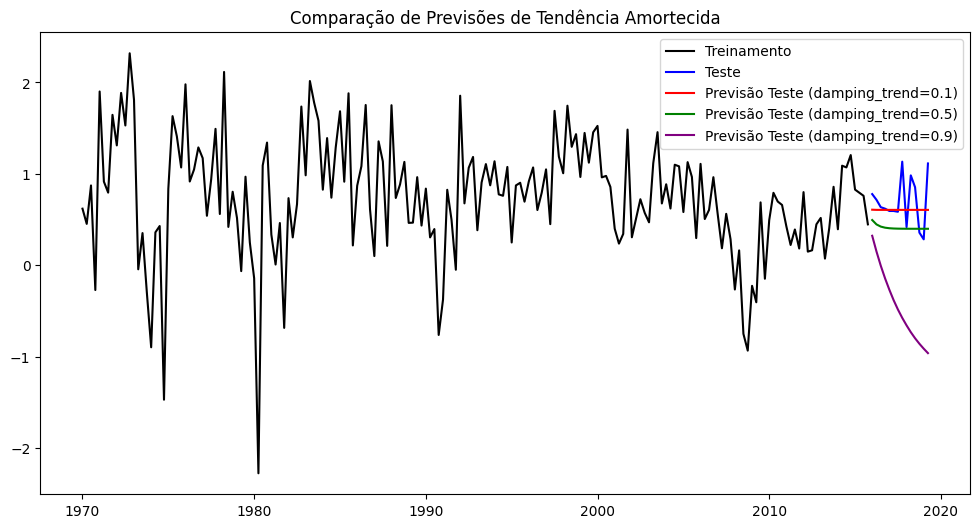

In [74]:
models = {'trend': 'add', 'seasonal': None, 'damped_trend': True}

# fixando os demais parâmetros em 0.5 para comparar apenas o damping trend
params = [
    {'smoothing_level': 0.5, 'smoothing_trend': 0.5, 'damping_trend': 0.1},
    {'smoothing_level': 0.5, 'smoothing_trend': 0.5, 'damping_trend': 0.5},
    {'smoothing_level': 0.5, 'smoothing_trend': 0.5, 'damping_trend': 0.9}
]

plot_all_models(
    y_train=y_train_transformed,
    y_test=y_test_transformed,
    models=models,
    params=params,
    offset=offset,
    title="Comparação de Previsões de Tendência Amortecida",
    label='damping_trend'
)


Esse método resolve o problema das previsões serem projetadas indefinidamente no futuro. Como visto em aula, normalmente o valor de $\phi$ é entre 0.8 e 0.99.

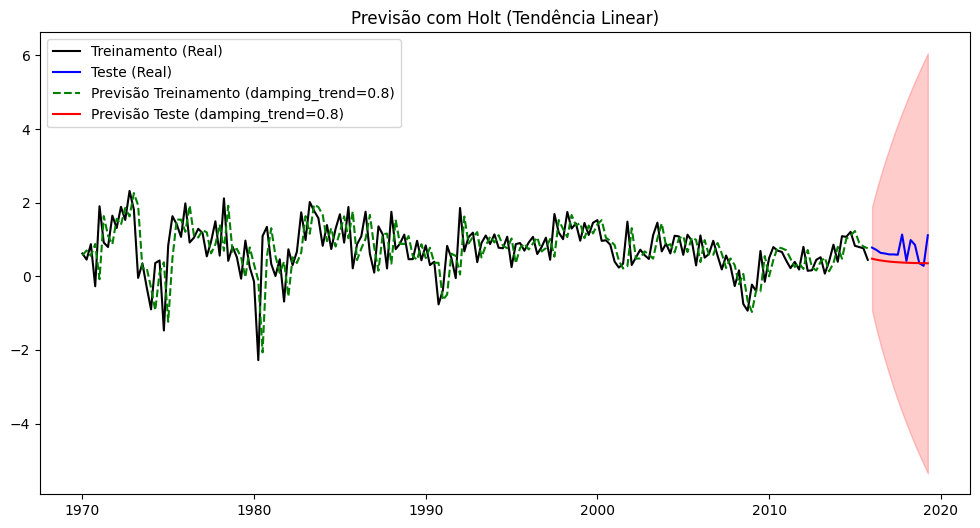

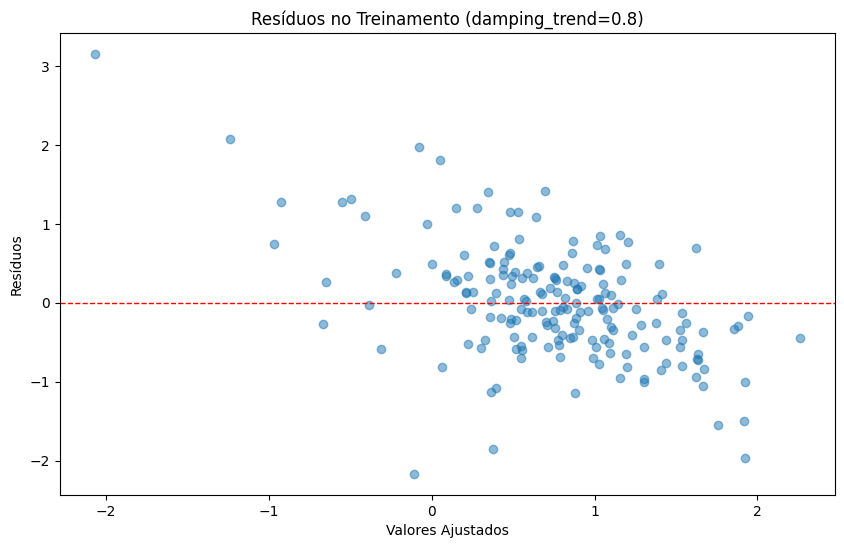

Métricas para o conjunto de teste:
MAE: 0.30983588146736835
MSE: 0.15426095943053988
RMSE: 0.3927606897724617
MAPE: 38.37891811027582%
R²: -1.4370382662677086
AIC: -20.16753396498855
BIC: -18.250361976142777

Teste de Ljung-Box:
     lb_stat  lb_pvalue
10  7.697635   0.658344


In [75]:
models = {'trend': 'add', 'seasonal': None, 'damped_trend': True}

params = {'smoothing_level': 0.8, 'smoothing_trend': 0.1, 'damping_trend': 0.8}

plot_model(
    y_train=y_train_transformed,
    y_test=y_test_transformed,  
    models=models,
    param=params,
    offset=offset,
    title="Previsão com Holt (Tendência Linear)",
    label='damping_trend'
)


### Método de Holt-Winters (Sazonalidade):


O **método de Holt-Winters** é uma extensão do método de Holt que incorpora um componente de **sazonalidade**. É ideal para séries temporais que exibem padrões repetitivos ao longo do tempo, como vendas mensais ou dados trimestrais com sazonalidade anual.

Existem duas variações principais:
1. **Sazonalidade Aditiva**: Para séries com sazonalidade constante.
2. **Sazonalidade Multiplicativa**: Para séries em que a magnitude da sazonalidade varia proporcionalmente ao nível da série.

##### **Equação de Previsão**
Para $h$ períodos à frente ($ \hat{y}_{T+h|T} $):

- **Sazonalidade Aditiva**:
  $$
  \hat{y}_{T+h|T} = l_T + h \cdot b_T + S_{T+h-m(k+1)}
  $$

- **Sazonalidade Multiplicativa**:
  $$
  \hat{y}_{T+h|T} = \left( l_T + h \cdot b_T \right) \cdot S_{T+h-m(k+1)}
  $$

- Onde:
  - $l_T$: Nível estimado no tempo $T$.
  - $b_T$: Tendência estimada no tempo $T$.
  - $S_{T+h-m(k+1)}$: Componente sazonal no tempo correspondente.
  - $m$: Período sazonal (ex.: 12 para dados mensais, 4 para trimestrais).
  - $k$: Número de ciclos completos passados.


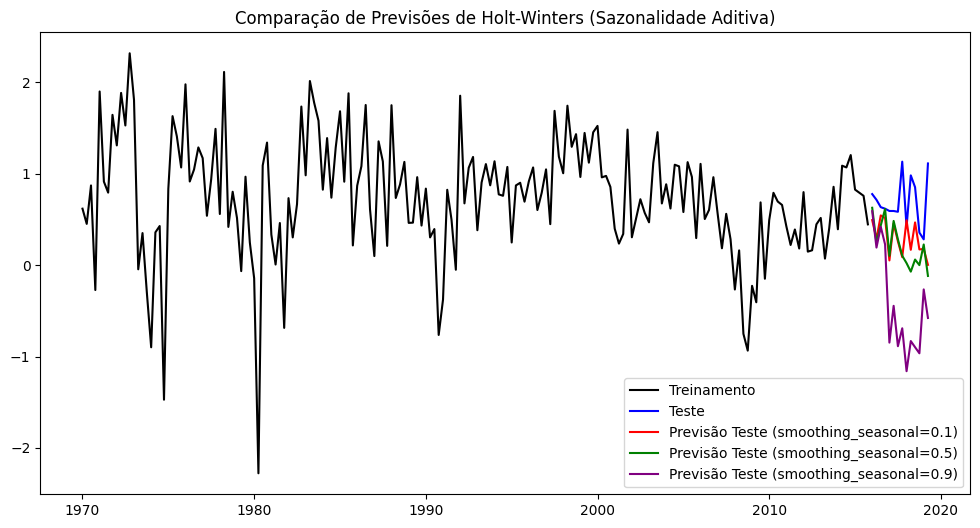

In [76]:
models = {'trend': 'add', 'seasonal': 'add', 'damped_trend': True, 'seasonal_periods': 12}

# fixando os demais parâmetros em 0.5 para comparar apenas o damping trend
params = [
    {'smoothing_level': 0.5, 'smoothing_trend': 0.1, 'damping_trend': 0.9, 'smoothing_seasonal': 0.1},
    {'smoothing_level': 0.5, 'smoothing_trend': 0.1, 'damping_trend': 0.9, 'smoothing_seasonal': 0.5},
    {'smoothing_level': 0.5, 'smoothing_trend': 0.1, 'damping_trend': 0.9, 'smoothing_seasonal': 0.9}
]

plot_all_models(
    y_train=y_train_transformed,
    y_test=y_test_transformed,
    models=models,
    params=params,
    offset=offset,
    title="Comparação de Previsões de Holt-Winters (Sazonalidade Aditiva)",
    label='smoothing_seasonal'
)


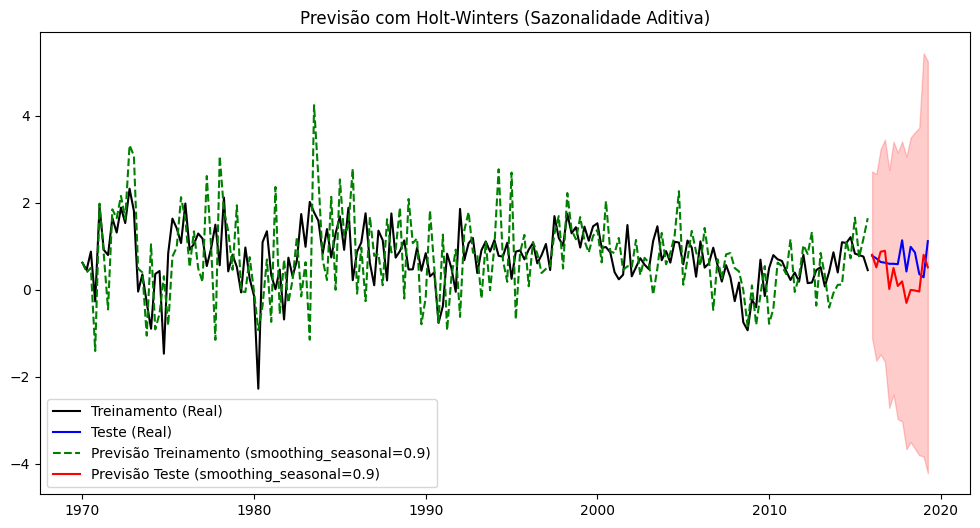

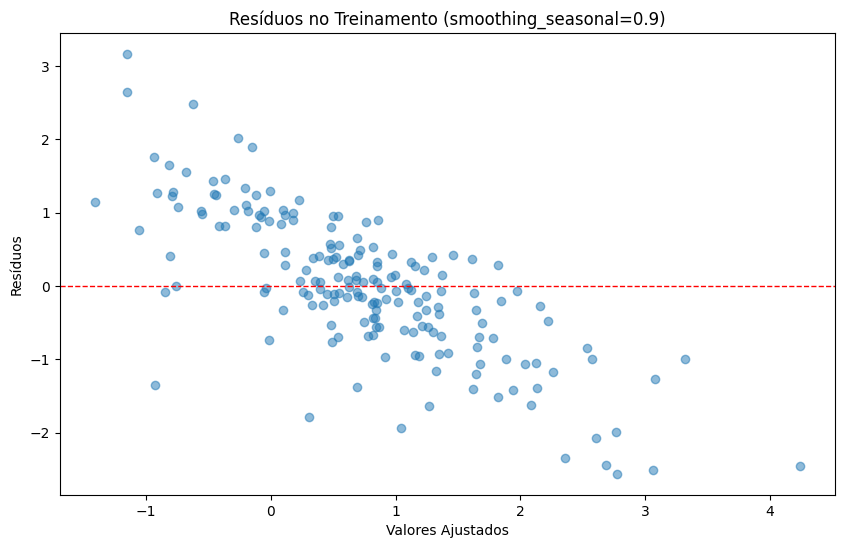

Métricas para o conjunto de teste:
MAE: 0.49726817997825884
MSE: 0.33671447893956447
RMSE: 0.5802710392045811
MAPE: 80.09071646354204%
R²: -4.3194669150985145
AIC: -7.23927931744652
BIC: -4.683049998985487

Teste de Ljung-Box:
      lb_stat  lb_pvalue
10  11.675987   0.307327


In [77]:
models = {'trend': 'add', 'seasonal': 'add', 'damped_trend': True, 'seasonal_periods': 12}

params = {'smoothing_level': 0.5, 'smoothing_trend': 0.1, 'damping_trend': 0.1, 'smoothing_seasonal': 0.9,}

plot_model(
    y_train=y_train_transformed,
    y_test=y_test_transformed,
    models=models,
    param=params,
    offset=offset,
    title="Previsão com Holt-Winters (Sazonalidade Aditiva)",
    label='smoothing_seasonal'
)


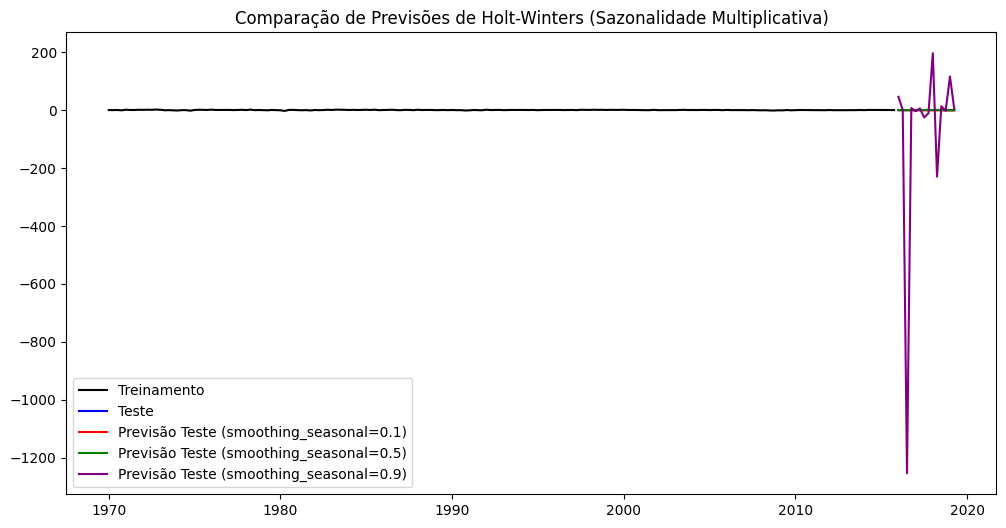

In [78]:
models = {'trend': 'add', 'seasonal': 'mul', 'damped_trend': True, 'seasonal_periods': 12}

# fixando os demais parâmetros em 0.5 para comparar apenas o damping trend
params = [
    {'smoothing_level': 0.5, 'smoothing_trend': 0.2, 'damping_trend': 0.9, 'smoothing_seasonal': 0.1},
    {'smoothing_level': 0.5, 'smoothing_trend': 0.2, 'damping_trend': 0.9, 'smoothing_seasonal': 0.5},
    {'smoothing_level': 0.5, 'smoothing_trend': 0.2, 'damping_trend': 0.9, 'smoothing_seasonal': 0.9}
]

plot_all_models(
    y_train=y_train_transformed,
    y_test=y_test_transformed,
    models=models,
    params=params,
    offset=offset,
    title="Comparação de Previsões de Holt-Winters (Sazonalidade Multiplicativa)",
    label='smoothing_seasonal'
)


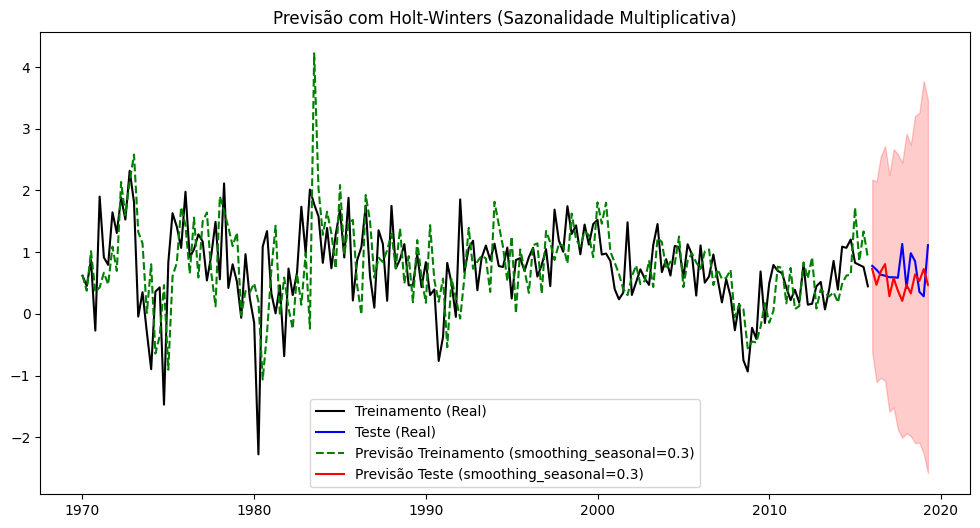

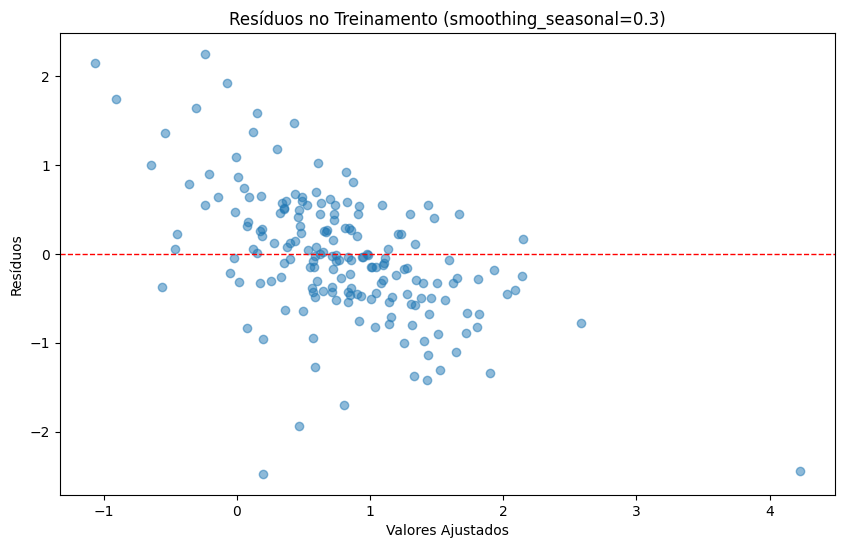

Métricas para o conjunto de teste:
MAE: 0.29837327457498397
MSE: 0.1578852679380598
RMSE: 0.39734779216457183
MAPE: 44.269290426328986%
R²: -1.4942956472291096
AIC: -17.842413268310914
BIC: -15.28618394984988

Teste de Ljung-Box:
     lb_stat  lb_pvalue
10  6.441197   0.776935


In [79]:
models = {'trend': 'add', 'seasonal': 'mul', 'damped_trend': True, 'seasonal_periods': 12}

params = {'smoothing_level': 0.5, 'smoothing_trend': 0.1, 'damping_trend': 0.1, 'smoothing_seasonal': 0.3}

plot_model(
    y_train=y_train_transformed,
    y_test=y_test_transformed,
    models=models,
    param=params,
    offset=offset,
    title="Previsão com Holt-Winters (Sazonalidade Multiplicativa)",
    label='smoothing_seasonal'
)


## Cross Validation

Após passar por todos os modelos, vamos utilizar o cross validation para descobrir os melhores parâmetros para o modelo.

In [63]:
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sklearn.model_selection import ParameterGrid
import numpy as np
import warnings
warnings.filterwarnings('ignore') 

# Configuração de parâmetros do modelo (categóricos)
model_param_grid = {
    "trend": ["add", None],
    "seasonal": ["add", "mul", None],
    "damped_trend": [True, False],
    "seasonal_periods": [4, 12]
}

# Configuração de parâmetros de ajuste (numéricos)
fit_param_grid = {
    "smoothing_level": [0.1, 0.3, 0.5, 0.7, 0.9],
    "smoothing_trend": [0.1, 0.3, 0.5, 0.7, 0.9],
    "damping_trend": [0.8, 0.85, 0.9, 0.95],
    "smoothing_seasonal": [0.1, 0.3, 0.5, 0.7, 0.9]
}

# Geração de combinações de parâmetros
model_combinations = list(ParameterGrid(model_param_grid))
fit_combinations = list(ParameterGrid(fit_param_grid))

# Divisor de validação cruzada
initial_window = int(len(y_train_transformed) * 0.5) 
step_length = 1
fh = 10  

cv = ExpandingWindowSplitter(
    initial_window=initial_window,
    step_length=step_length,
    fh=fh
)

# Métrica de erro
mape = MeanAbsolutePercentageError(symmetric=True)

# Função de avaliação
# Função de avaliação corrigida
def evaluate_model(y_train, model_params, fit_params, cv, offset):
    scores = []
    for train_idx, val_idx in cv.split(y_train):
        # Separar os conjuntos de treinamento e validação
        y_train_cv = y_train.iloc[train_idx]
        y_val_cv = y_train.iloc[val_idx]
        
        # Transformar os dados
        y_train_trans, y_val_trans, offset_cv = transform_data_global(y_train_cv, y_val_cv)
        
        try:
            # Criar e ajustar o modelo
            model = ETSModel(y_train_trans, **model_params)
            fit = model.fit_constrained(fit_params, disp=0)
            
            # Fazer previsões
            y_pred = fit.forecast(steps=len(y_val_cv))
            
            # Alinhar os índices de y_pred com y_val_cv
            y_pred.index = y_val_cv.index
            
            # Reverter transformação
            y_val_inv = inverse_transform_data(y_val_trans, offset_cv)
            y_pred_inv = inverse_transform_data(y_pred, offset_cv)
            
            # Calcular o erro
            score = mape(y_val_inv, y_pred_inv)
            scores.append(score)
        except Exception as e:
            # Ignorar erros para combinações inválidas
            print(f"Erro com parâmetros {model_params}, {fit_params}: {e}")
            return np.inf
    
    return np.mean(scores)

# Avaliação de todas as combinações
best_score = float("inf")
best_model_params = None
best_fit_params = None

for model_params in model_combinations:
    for fit_params in fit_combinations:
        score = evaluate_model(y_train, model_params, fit_params, cv, offset)
        print(f"Model: {model_params}, Fit: {fit_params}, Erro: {score}")
        
        if score < best_score:
            best_score = score
            best_model_params = model_params
            best_fit_params = fit_params

print(f"Melhores parâmetros do modelo: {best_model_params}")
print(f"Melhores parâmetros de ajuste: {best_fit_params}")
print(f"Melhor erro: {best_score}")

Model: {'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 4, 'trend': 'add'}, Fit: {'damping_trend': 0.8, 'smoothing_level': 0.1, 'smoothing_seasonal': 0.1, 'smoothing_trend': 0.1}, Erro: 0.7988579710507632
Model: {'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 4, 'trend': 'add'}, Fit: {'damping_trend': 0.8, 'smoothing_level': 0.1, 'smoothing_seasonal': 0.1, 'smoothing_trend': 0.3}, Erro: 0.8893200254987708
Model: {'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 4, 'trend': 'add'}, Fit: {'damping_trend': 0.8, 'smoothing_level': 0.1, 'smoothing_seasonal': 0.1, 'smoothing_trend': 0.5}, Erro: 0.9170932921011513
Model: {'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 4, 'trend': 'add'}, Fit: {'damping_trend': 0.8, 'smoothing_level': 0.1, 'smoothing_seasonal': 0.1, 'smoothing_trend': 0.7}, Erro: 0.9613858566198662
Model: {'damped_trend': True, 'seasonal': 'add', 'seasonal_periods': 4, 'trend': 'add'}, Fit: {'damping_trend': 0.8, 'smoothing_

KeyboardInterrupt: 

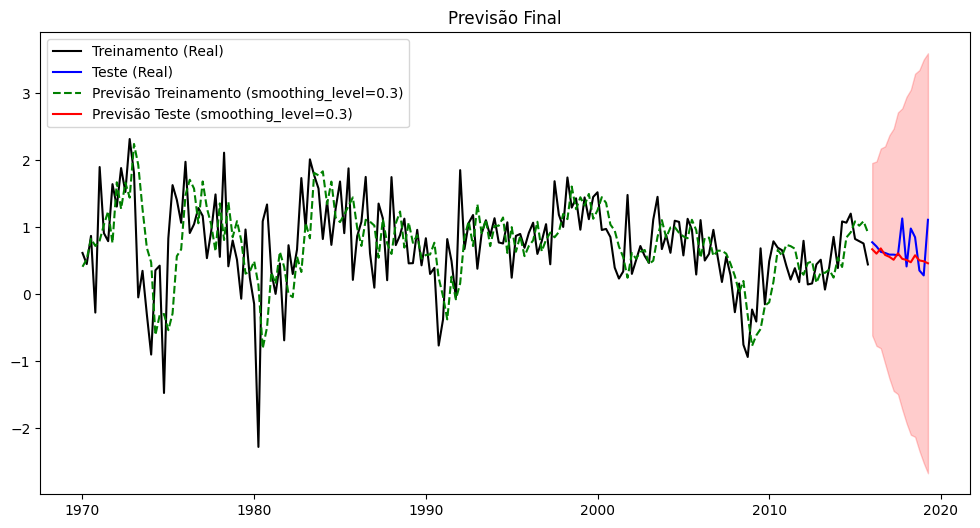

In [18]:
# plotar a previsão final
plot_model(
    y_train=y_train_transformed,
    y_test=y_test_transformed,
    models=best_model_params,
    param=best_fit_params,
    offset=offset,
    title="Previsão Final",
    label='smoothing_level'    
)

